In [30]:
import os
import pickle

import pandas as pd
import scipy.stats as stats
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

import egoviz.models.processing as pr
import egoviz.models.evaluation as ev

In [6]:
SEED = 42

### Load DataFrame

In [2]:
cwd = os.getcwd()
file_path = os.path.join(cwd, '../data/home_data_all_preds_df.pkl')
df = pr.load_pickle(file_path)
df = pr.generate_counts_df(df)

### Split into X and y and get groups

In [3]:
X = df.drop(['adl', 'video'], axis=1)
y = df['adl']
groups = df['video'].str[:5]

In [5]:
# convert labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [18]:
param_distributions = {
    'learning_rate': stats.uniform(0.01, 0.2 - 0.01),
    'n_estimators': stats.randint(100, 301),
    'max_depth': stats.randint(3, 6),
    'subsample': stats.uniform(0.8, 1.0 - 0.8),
    'colsample_bytree': stats.uniform(0.8, 1.0 - 0.8),
    'min_child_weight': stats.randint(1, 11),
    'gamma': stats.uniform(0, 0.2),
    'scale_pos_weight': stats.randint(1, 6)
}

In [19]:
# Create a GroupKFold object
group_kfold = GroupKFold(n_splits=16)

# Create an XGBClassifier object
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), eval_metric='mlogloss', random_state=SEED, tree_method='gpu_hist')

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_distributions, n_iter=10, scoring='f1_macro', cv=group_kfold, verbose=999, n_jobs=-1, return_train_score=True, random_state=SEED)
random_search.fit(X, y_encoded, groups=groups)

Fitting 16 folds for each of 10 candidates, totalling 160 fits


c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=GroupKFold(n_splits=16),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_co...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000237606B94D0>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023770C46710>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023770BFADD0>},
                   random_state=42, return_train_score=True, scoring='f1_macro',
                   verbose=999)

In [23]:
# Get the best parameters
best_params = random_search.best_params_

# Get the results as a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Print the best parameters
print("Best Parameters:", best_params)

# show all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame of results
print("\nResults DataFrame:")
results_df

Best Parameters: {'colsample_bytree': 0.8650660661526529, 'gamma': 0.07773545793789641, 'learning_rate': 0.061556316037040225, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 253, 'scale_pos_weight': 1, 'subsample': 0.8561869019374762}

Results DataFrame:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,mean_train_score,std_train_score
0,86.533121,0.840663,0.657319,0.020518,0.874908,0.190143,0.149079,3,5,202,2,0.831199,"{'colsample_bytree': 0.8749080237694725, 'gamm...",0.511523,0.513767,0.245759,0.250283,0.437262,0.266657,0.489173,0.392235,0.437829,0.203223,0.512393,0.432484,0.266974,0.700073,0.292749,0.333333,0.392857,0.131215,4,0.999519,0.999596,0.999327,0.999461,0.997518,0.998912,0.999452,0.998026,0.998684,0.998282,0.999474,0.999467,0.998860,0.998887,0.998037,0.998953,0.998903,0.000621
1,77.809638,1.587590,0.498915,0.013867,0.811617,0.173235,0.124212,5,6,152,2,0.9444,"{'colsample_bytree': 0.8116167224336399, 'gamm...",0.523727,0.461065,0.299549,0.238637,0.406504,0.268636,0.522388,0.299913,0.531633,0.357143,0.450728,0.382894,0.266974,0.505613,0.319712,0.333333,0.385528,0.098704,7,0.999588,0.999596,1.000000,0.998125,0.999582,1.000000,1.000000,0.999237,1.000000,1.000000,1.000000,0.999579,0.999599,0.999562,1.000000,0.999608,0.999655,0.000460
2,53.286115,0.284069,0.428894,0.011726,0.987711,0.000156,0.19852,3,10,121,5,0.886389,"{'colsample_bytree': 0.98771054180315, 'gamma'...",0.504702,0.507639,0.245360,0.261560,0.433270,0.258587,0.517107,0.351887,0.432667,0.199062,0.519138,0.364421,0.264932,0.667416,0.298955,0.333333,0.385002,0.127592,8,0.987260,0.990112,0.975059,0.981076,0.985231,0.984713,0.985419,0.985901,0.988978,0.988278,0.983757,0.984279,0.986736,0.986745,0.983071,0.985278,0.985118,0.003399
3,116.453400,0.307399,0.721657,0.019460,0.858246,0.122371,0.036504,5,3,207,4,0.918483,"{'colsample_bytree': 0.8582458280396084, 'gamm...",0.472142,0.506160,0.237438,0.265640,0.432557,0.259226,0.497614,0.300353,0.433954,0.289084,0.443449,0.404778,0.326641,0.713082,0.369860,0.333333,0.392832,0.118477,5,0.988238,0.994595,0.981762,0.988103,0.988612,0.991332,0.990945,0.988692,0.990220,0.989447,0.989418,0.987487,0.991831,0.987967,0.988368,0.988851,0.989117,0.002598
4,131.104339,0.326026,0.795803,0.039975,0.80929,0.121509,0.0424,5,2,231,1,0.993126,"{'colsample_bytree': 0.8092900825439996, 'gamm...",0.470461,0.497658,0.238018,0.299457,0.405031,0.256414,0.510483,0.290491,0.518090,0.261703,0.450728,0.361936,0.320357,0.727513,0.345802,0.333333,0.392967,0.125743,3,1.000000,1.000000,0.997269,0.999461,0.998174,0.999354,0.998301,0.998191,0.998857,0.998282,0.998282,0.997864,0.998860,0.998814,0.998956,0.998415,0.998692,0.000724
5,151.702986,0.677643,0.901615,0.018407,0.961679,0.060923,0.028558,5,7,271,5,0.966639,"{'colsample_bytree': 0.9616794696232922, 'gamm...",0.467532,0.496265,0.250112,0.263137,0.446551,0.254529,0.458001,0.362758,0.433954,0.215664,0.443449,0.378159,0.332621,0.727513,0.333040,0.333333,0.387289,0.122155,6,0.973893,0.979406,0.957319,0.970494,0.974866,0.976804,0.971600,0.971177,0.977487,0.973580,0.972121,0.972197,0.976698,0.972057,0.972108,0.973049,0.972803,0.004703
6,77.092258,0.625873,0.536672,0.012083,0.834673,0.078212,0.044625,4,6,153,2,0.91354,"{'colsample_bytree': 0.8346729307015545, 'gamm...",0.472257,0.479857,0.232710,0.227728,0.447139,0.254529,0.433336,0.349090,0.530800,0.207504,0.435856,0.387657,0.332621,0.713082,0.317783,0.333333,0.384705,0.127958,9,0.954780,0.958889,0.91

In [24]:
# add best params to classifier
xgb_clf.set_params(**best_params)

{'colsample_bytree': 0.8650660661526529,
 'gamma': 0.07773545793789641,
 'learning_rate': 0.061556316037040225,
 'max_depth': 3,
 'min_child_weight': 8,
 'n_estimators': 253,
 'scale_pos_weight': 1,
 'subsample': 0.8561869019374762}

In [27]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = sorted(set(y))

# Calculate class weights
class_weights = dict(zip(unique_classes, compute_class_weight('balanced', classes=unique_classes, y=y)))

In [28]:
# best params without scale_pos_weight
best_params_no_scale_pos_weight = best_params.copy()
del best_params_no_scale_pos_weight['scale_pos_weight']

# add best params to classifier
xgb_clf2 = XGBClassifier(objective='multi:softmax', num_class=len(unique_classes), eval_metric='mlogloss', random_state=SEED, tree_method='gpu_hist', scale_pos_weight=class_weights, **best_params_no_scale_pos_weight)

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
2023-11-18 02:26:43,856 - root - INFO - Training complete for XGBClassifier, group left out: SCI02
c:\Users\adesh\AppData\Local

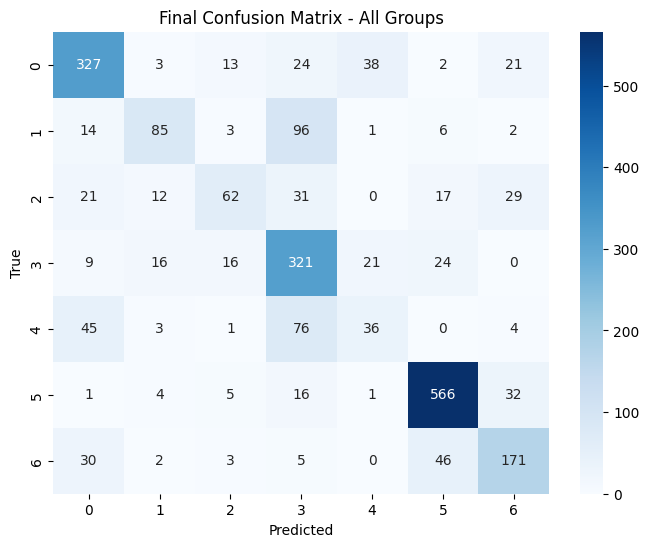

2023-11-18 02:27:17,267 - root - INFO - LOGOCV complete for XGBClassifier


XGBoost Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.895833,0.858289,0.421745,0.435856,0.686472,0.559138,0.627722,0.481498
1,SCI03,0.765625,0.510928,0.548916,0.526667,0.686472,0.559138,0.627722,0.481498
2,SCI06,0.621359,0.491051,0.241342,0.485181,0.686472,0.559138,0.627722,0.481498
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.686472,0.559138,0.627722,0.481498
4,SCI10,0.518349,0.393991,0.787570,0.268461,0.686472,0.559138,0.627722,0.481498
5,SCI11,0.747475,0.402035,0.388286,0.679205,0.686472,0.559138,0.627722,0.481498
6,SCI12,0.640909,0.517595,0.566234,0.506763,0.686472,0.559138,0.627722,0.481498
7,SCI13,0.706215,0.524200,0.738272,0.337057,0.686472,0.559138,0.627722,0.481498
8,SCI14,0.625000,0.559737,0.581304,0.608877,0.686472,0.559138,0.627722,0.481498
9,SCI15,0.894118,0.570168,0.704252,0.730076,0.686472,0.559138,0.627722,0.481498


In [32]:
xgb_active = ev.leave_one_group_out_cv(df, X, y_encoded, groups, xgb_clf2, xgb=True)
print('XGBoost Classifier')
xgb_active